BEST


enc_seq_len = 20#10
dec_seq_len = 10#4
output_sequence_length = 1

dim_val = 10
dim_attn = 9
input_size = 1 # число признаков
lr = 0.002
epochs = 20

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 150#15

init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

keep track of loss for graph
losses = []

In [ ]:
!pip install investpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
 
from sklearn.preprocessing import MinMaxScaler
 
%matplotlib notebook
import matplotlib.pyplot as plt
 
import pandas as pd
 
from datetime import date
from datetime import datetime
import datetime

 
import os

import investpy

import random
 
%matplotlib inline
 
PATH = '/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/dayUS/'

In [ ]:
def train(instrument_data, batch_size, epochs):
  #keep track of loss for graph
  losses = []
 
  #build live matplotlib fig
  fig = plt.figure()
 
  ax = fig.add_subplot(111)
  plt.ion()
 
  fig.show()
  fig.canvas.draw()
      
  for e in range(epochs):
      out = []
      
      # for b in range(enc_seq_len):  # 20 раз всего. поменять на что то большее?
      for b in range(MY_FORCE*int(len(instrument_data)/batch_size)):
          optimizer.zero_grad()
          X, y = get_data(instrument_data, batch_size, enc_seq_len, output_sequence_length)
          
          #Forward pass and calculate loss
          net_out = t(X)
          #print(net_out.shape,Y.shape)
          loss = torch.mean((net_out - y) ** 2)
 
          #backwards q
          optimizer.step()
          #print(loss, e)
 
      #Track losses and draw rgaph
      out.append([net_out.detach().numpy(), y])
      losses.append(loss)
      ax.clear()
      ax.plot(losses)
      ax.set_title("Mean Squared Error")
      fig.canvas.draw()
      # plt.show() 
      print(loss, e) 
  return t, losses
      
def pred(X_test, t):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.ion()
 
  fig.show()
  fig.canvas.draw()
  #true_seq = scaler.inverse_transform(instrument_data.reshape(-1, 1))
  x = [X_test[0].tolist()]
  N = X_test.shape[0] #- (enc_seq_len + output_sequence_length)
 
  #Draw graph 
  for i in range(N): 
    q = torch.tensor([X_test[i].tolist()]).float()  
    
    #if(output_sequence_length == 1):
    y_pred = [t(q).detach().squeeze().numpy()]
    
    x[0].append(y_pred)
 
  prediction = scaler.inverse_transform(x[0])
  ax.clear()
  ax.plot(prediction, label='Network output')
  ax.plot(true_seq, label='y_true')
  ax.set_title("")
  ax.legend(loc='upper left', frameon=False);
 
  return prediction

In [ ]:
def predi():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()
  #true_seq = scaler.inverse_transform(instrument_data.reshape(-1, 1))
  x = [X_test[0].tolist()]
  N = X_test.shape[0] #- (enc_seq_len + output_sequence_length)

  #Draw graph 
  for i in range(N): 
    q = torch.tensor([X_test[i].tolist()]).float()  
    
    #if(output_sequence_length == 1):
    y_pred = [t(q).detach().squeeze().numpy()]
    
    x[0].append(y_pred)

  prediction = scaler.inverse_transform(x[0])
  ax.clear()
  ax.plot(prediction, label='Network output')
  ax.plot(true_seq, label='y_true')
  ax.set_title("")
  ax.legend(loc='upper left', frameon=False);

  prediction = prediction.flatten()

  return(prediction)
# prediction = predi()

def traina(data, epochs = 5, MY_FORCE = 5):
  #init network and optimizer
  t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
  optimizer = torch.optim.Adam(t.parameters(), lr=lr)

  #keep track of loss for graph
  losses = []
  
  #build live matplotlib fig
  fig = plt.figure()
  
  ax = fig.add_subplot(111)
  plt.ion()
  
  fig.show()
  fig.canvas.draw()

  print('batch_size: {} enc_seq_len: {} len(instrument_data): {})'.format(batch_size, enc_seq_len, len(instrument_data)))    
  print('my_force: {}'.format(int(MY_FORCE*(len(instrument_data)/batch_size))))
  for e in range(epochs):
      out = []
      
      # for b in range(enc_seq_len):  # 20 раз всего. поменять на что то большее?
      for b in range(int(MY_FORCE*(len(instrument_data)/batch_size))):
          optimizer.zero_grad()
          X, y = get_data(instrument_data, batch_size, enc_seq_len, output_sequence_length)  # поменял на reverse
          # X, y = get_data_reverse(instrument_data, batch_size, enc_seq_len, output_sequence_length, year_train)
          
          #Forward pass and calculate loss
          net_out = t(X)
          #print(net_out.shape,Y.shape)
          loss = torch.mean((net_out - y) ** 2)
  
          #backwards pass
          loss.backward()
          optimizer.step()
          # print(loss, e)
  
      #Track losses and draw rgaph
      print(loss, e)
      out.append([net_out.detach().numpy(), y])
      losses.append(loss)
      ax.clear()
      ax.plot(losses)
      ax.set_title("Mean Squared Error")
      fig.canvas.draw()
      # plt.show()
  print(batch_size)
  return t

### 1. Модель

#### Scaled Dot-Product Attention

Функция внимания, используемая преобразователем, принимает три входа: Q (запрос), K (ключ), V (значение). Уравнение, используемое для расчета весов внимания:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [ ]:
def attention(Q, K, V):
    m = torch.matmul(Q, K.transpose(2, 1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
 
    a = torch.softmax(m , -1) #(batch_size, dim_attn, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)
 
class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.query = Query(dim_val, dim_attn)
        self.key = Key(dim_val, dim_attn)
        self.value = Value(dim_val, dim_val)        
        
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q, K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
 
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x
 
class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x
 
class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        
        x = self.fc1(x)
        #print(x.shape)
        #x = self.fc2(x)
        
        return x
 
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
 
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(data, batch_size, input_sequence_length, output_sequence_length, train=True):
  """
  train, test: np.array, shape(n, )
 
  """  
  i = input_sequence_length + output_sequence_length
  if train:
    t = torch.zeros(batch_size, 1).uniform_(0, len(instrument_data) - i).int()
  else:    
    batch_size = len(data) - i
    t = torch.arange(0, batch_size).reshape(-1, 1)
  
  b = torch.arange(0, i).unsqueeze(0).repeat(batch_size, 1) + t
  s = torch.FloatTensor(data[b])
  X, y = s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]
 
  return X, y

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, 
                 n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        
        return x

### 2. Гиперпраметры модели

In [ ]:
#hyperparams
enc_seq_len = 20#10
dec_seq_len = 10#4
output_sequence_length = 1
 
dim_val = 10
dim_attn = 9
input_size = 1 # число признаков
lr = 0.002
epochs = 5
 
n_heads = 3 
 
n_decoder_layers = 3
n_encoder_layers = 3
 
 
#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)
 
MY_FORCE = 10

DIR = 'dayUS/'
# stock = 'US1.TSLA_101201_201201.csv'
# stock = 'US1.FB_101201_201201.csv'
# stock = 'US1.AMZN_101201_201201.csv'
stock = 'US1.MSFT_101201_201201.csv'
# stock = 'SPFB.RTS.csv'
# stock = 'LKOH.csv'

### 3. Подготовка данных для модели

In [ ]:
#hyperparams
enc_seq_len = 10
dec_seq_len = 4
output_sequence_length = 1

dim_val = 10
dim_attn = 9
input_size = 1 # число признаков
lr = 0.002
epochs = 5

n_heads = 3 

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = int(len(array_for_model)/5)

#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

#### From csv

In [ ]:
def get_dummy_data(x, close = '<CLOSE>'):
  # return np.cos(x)
  # return np.arange(1, 100, 1)
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/'+ DIR + stock)
  print(type(data))
  data = data.iloc[:x, :]
  return np.array(data[close]), data
  
def get_dummy_data_test(x, close = '<CLOSE>'):
  # return np.cos(x)
  # return np.arange(1, 100, 1)
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/'+ DIR + stock)
  print(type(data))
  data = data.iloc[x:, :]
  return np.array(data[close]), data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR +  stock)
x = int(len(data)*0.7)
close = '<CLOSE>' 
# x = np.arange(2000, dtype=np.float32)
instrument_data, year_train = get_dummy_data(x, close)
 
scaler = MinMaxScaler()
instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()

# test_data = np.arange(100, 150, dtype=np.float32)
test_data, year_test = get_dummy_data_test(x, close)
true_seq = test_data.copy()

test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
print(stock, instrument_data.shape, X_test.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
US1.MSFT_101201_201201.csv (1761,) torch.Size([735, 20, 1]) torch.Size([735, 1])


#### From InvestRU

In [ ]:
#Function "returns" based on https://www.coursera.org/learn/introduction-portfolio-construction-python/home/welcome
def returns(prices):
  prices = prices.pct_change()
  return np.array(prices[~np.isnan(prices)])*100

In [ ]:
today = datetime.datetime.today().strftime('%d/%m/%Y')
df = investpy.get_stock_historical_data(stock='BABA',
                                        country='United States',
                                        from_date='01/01/2010',
                                        to_date=today)
dataset = pd.DataFrame(df['Close'])
array_for_model = returns(dataset['Close'])
len(array_for_model), len(dataset)

(1741, 1742)

In [ ]:
def get_dummy_data(x):
  return np.cos(x)

#x = np.arange(100, dtype=np.float32)
two_thirds = int(round(len(array_for_model)*75/100))
#instrument_data = get_dummy_data(x)
instrument_data = array_for_model[:two_thirds]

scaler = MinMaxScaler()
instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()

print(instrument_data.shape)

(1306,)


In [ ]:
#test_data = np.arange(100, 150, dtype=np.float32)
#test_data = get_dummy_data(test_data)
test_data = array_for_model[two_thirds:]
true_seq = test_data.copy()

test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
print( X_test.shape, y_test.shape)

torch.Size([414, 20, 1]) torch.Size([414, 1])


### "Бог не играет в кости"

In [ ]:
# В year_train === instrument_data создали столбец weight_strong который принимает2 значения в зависимости от движения рынка завтра. Если сильное движение вес меньше, если сильное - вес больше.
# с помощью  random.choices выводим индексы в зависимости от веса. Индексы где weight_strong выше, выводятся чаще. Таким образом мы можем сформировать t из get_data_reverse но не случайно а в зависимости от 
#  весов. 
# t_np = []
# year_train['weight'] = (year_train[close]/year_train[close].shift(1) - 1)*100
# year_train.fillna(0, inplace=True)
# year_train['weight_strong'] = np.where(year_train['weight'] < 0, 0.9, 0)
# year_train['index'] = year_train.index
# for number in range(batch_size):
#   idx = random.choices(year_train['index'], weights=year_train['weight_strong'])
#   t_np.append(idx) 

In [ ]:
def get_data_reverse(data, batch_size, input_sequence_length, output_sequence_length, year_train, train=True):
  """
  train, test: np.array, shape(n, )
 
  """
  close = '<CLOSE>'  
  i = input_sequence_length + output_sequence_length
  if train:
    t_np = []
    year_train['weight'] = abs(year_train[close]/year_train[close].shift(1) - 1)*100
    year_train.fillna(0, inplace=True)
    year_train['weight_strong'] = np.where(year_train['weight'] > 0.5, 49/50, 0/50)
    year_train['index'] = year_train.index

    for number in range(batch_size):

      # print(number)      
      t_np.append(random.choices(year_train['index'], weights=year_train['weight_strong']))    
    t = torch.tensor(t_np)  # выдает 1 индекс 

    # t = torch.zeros(batch_size, 1).uniform_(i, len(data)).int()
    # print(torch.min(t), torch.max(t))
  else:    
    batch_size = len(data) - i
    t = torch.arange(0, batch_size).reshape(-1, 1)
  # print(t)
  # print('dddddd')
  # print(t_np)
  b = t - torch.arange(i, -1, -1).unsqueeze(0).repeat(batch_size, 1)  # индекс минус от 0 до 
  # print(b, b.shape)
  s = torch.FloatTensor(data[b])
  # print(s)
  X, y = s[:, :input_sequence_length+1].unsqueeze(-1), s[:,-output_sequence_length:]

  return X, y 
# X, y = get_data_reverse(np.array(year_train[close]), batch_size, enc_seq_len, output_sequence_length, year_train)
# year_train[year_train.index.isin(np.squeeze(np.array(t_np)))]['weight_strong'].value_counts()

### 4. Обучение модели

tensor(0.0618, grad_fn=<MeanBackward0>) 0
tensor(0.0196, grad_fn=<MeanBackward0>) 1
tensor(0.0078, grad_fn=<MeanBackward0>) 2
tensor(0.0023, grad_fn=<MeanBackward0>) 3
tensor(0.0015, grad_fn=<MeanBackward0>) 4
tensor(0.0017, grad_fn=<MeanBackward0>) 5
tensor(0.0016, grad_fn=<MeanBackward0>) 6
tensor(0.0016, grad_fn=<MeanBackward0>) 7
tensor(0.0017, grad_fn=<MeanBackward0>) 8
tensor(0.0015, grad_fn=<MeanBackward0>) 9
tensor(0.0018, grad_fn=<MeanBackward0>) 10
tensor(0.0019, grad_fn=<MeanBackward0>) 11
tensor(0.0015, grad_fn=<MeanBackward0>) 12
tensor(0.0020, grad_fn=<MeanBackward0>) 13
tensor(0.0015, grad_fn=<MeanBackward0>) 14
tensor(0.0015, grad_fn=<MeanBackward0>) 15
tensor(0.0015, grad_fn=<MeanBackward0>) 16
tensor(0.0015, grad_fn=<MeanBackward0>) 17
tensor(0.0014, grad_fn=<MeanBackward0>) 18
tensor(0.0015, grad_fn=<MeanBackward0>) 19
tensor(0.0015, grad_fn=<MeanBackward0>) 20
tensor(0.0013, grad_fn=<MeanBackward0>) 21
tensor(0.0014, grad_fn=<MeanBackward0>) 22
tensor(0.0015, grad_f

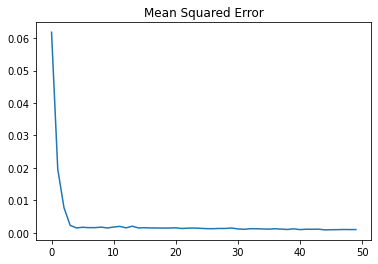

In [ ]:
%%time

MY_FORCE = 10
epochs = 50


#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []
 
#build live matplotlib fig
fig = plt.figure()
 
ax = fig.add_subplot(111)
plt.ion()
 
fig.show()
fig.canvas.draw()
    
for e in range(epochs):
    out = []
    
    for b in range(enc_seq_len):  # 20 раз всего. поменять на что то большее?
    # for b in range(int(MY_FORCE*(len(instrument_data)/batch_size))):
        optimizer.zero_grad()
        X, y = get_data(instrument_data, batch_size, enc_seq_len, output_sequence_length)  # поменял на reverse
        # X, y = get_data_reverse(instrument_data, batch_size, enc_seq_len, output_sequence_length, year_train)
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - y) ** 2)
 
        #backwards pass
        loss.backward()
        optimizer.step()
        # print(loss)
 
    #Track losses and draw rgaph
    print(loss, e)
    out.append([net_out.detach().numpy(), y])
    losses.append(loss)
    ax.clear()
    ax.plot(losses)
    ax.set_title("Mean Squared Error")
    fig.canvas.draw()
    # plt.show()
# print(losses)

### 5. Предсказания модели

CPU times: user 4.53 s, sys: 37 ms, total: 4.56 s
Wall time: 4.57 s


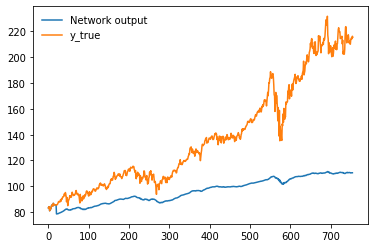

In [ ]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
#true_seq = scaler.inverse_transform(instrument_data.reshape(-1, 1))
x = [X_test[0].tolist()]
N = X_test.shape[0] #- (enc_seq_len + output_sequence_length)

#Draw graph 
for i in range(N): 
  q = torch.tensor([X_test[i].tolist()]).float()  
  
  #if(output_sequence_length == 1):
  y_pred = [t(q).detach().squeeze().numpy()]
  
  x[0].append(y_pred)

prediction = scaler.inverse_transform(x[0])
ax.clear()
ax.plot(prediction, label='Network output')
ax.plot(true_seq, label='y_true')
ax.set_title("")
ax.legend(loc='upper left', frameon=False);

prediction = prediction.flatten()

### 6. Оценка качества предсказаний

#### Pearson product-moment correlation coefficients

In [ ]:
prediction = prediction.flatten()

np.corrcoef(prediction, true_seq[:-1])

array([[1.        , 0.96092332],
       [0.96092332, 1.        ]])

#### RMSE

In [ ]:
np.sqrt(((prediction - true_seq[:-1])**2).sum())

1430.4998092830417

### 7. Финансовый результат

#### FOR RETURN

In [ ]:
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq[:-1]})
profit_table['forecast'] = np.where(profit_table['forec'] > 0, 1, -1)
profit_table['tru_label'] = np.where(profit_table['true_seq'] > 0, 1, -1)
profit_table['Accura']   = np.where(profit_table['forecast']*profit_table['tru_label'] == 1, 1, 0)
profit_table
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = 'forecast',
                values = ['true_seq', 'Accura'],
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

count            mean         
         Accura true_seq Accura true_seq
forecast                                
-1          153      153   0.56    -0.20
1           281      281   0.52     0.08
All         434      434   0.53    -0.02

#### FOR PRICE

In [ ]:
threshold = 0.
index_for = ['forecast_threshold']
 
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq[:-1]})
profit_table['Profit']   = ((profit_table['true_seq'].shift(-1) / profit_table['true_seq']- 1) * 100)
profit_table['Accura']   = np.where(profit_table['Profit'] > 0, 1, 0)
profit_table['Profit_forec']   = ((profit_table['forec'].shift(-1) / profit_table['forec']- 1) * 100)
profit_table['forecast'] = np.where((profit_table['forec'].shift(-1) / profit_table['forec']- 1) > 0, 1, -1)
profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
profit_table['Dif']      = (profit_table['true_seq'] - profit_table['forecast']) / profit_table['true_seq']  
profit_table['Data']     = np.array(year_test['<DATE>'][:-1])
profit_table['Data']     = np.array(pd.to_datetime(profit_table['Data']))
profit_table['Year'] = profit_table['Data'].dt.year
profit_table['Profit'] = np.where(profit_table['Profit']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit']))
profit_table['Profit_forec'] = np.where(profit_table['Profit_forec']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit_forec']))
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = index_for,
                values = ['Profit', 'Accura'],
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

count          mean       
                   Accura Profit Accura Profit
forecast_threshold                            
-1                    243    243   0.62   0.51
1                     511    511   0.54  -0.02
All                   754    754   0.57   0.15

# Обучение и прогнозирование в цикле

US1.MSFT_101201_201201.csv
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1761,) torch.Size([735, 20, 1]) torch.Size([735, 1])
batch_size: 585 enc_seq_len: 20 len(instrument_data): 1761)
my_force: 30
tensor(0.0009, grad_fn=<MeanBackward0>) 0
tensor(0.0006, grad_fn=<MeanBackward0>) 1
tensor(0.0005, grad_fn=<MeanBackward0>) 2
tensor(0.0004, grad_fn=<MeanBackward0>) 3
tensor(0.0004, grad_fn=<MeanBackward0>) 4
585
US1.AMZN_101201_201201.csv
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1762,) torch.Size([735, 20, 1]) torch.Size([735, 1])
batch_size: 585 enc_seq_len: 20 len(instrument_data): 1762)
my_force: 30
tensor(0.0049, grad_fn=<MeanBackward0>) 0
tensor(0.0014, grad_fn=<MeanBackward0>) 1
tensor(0.0012, grad_fn=<MeanBackward0>) 2
tensor(0.0011, grad_fn=<MeanBackward0>) 3
tensor(0.0010, grad_fn=<MeanBackward0>) 4
585
US1.FB_101201_201201.csv
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1504,) tor

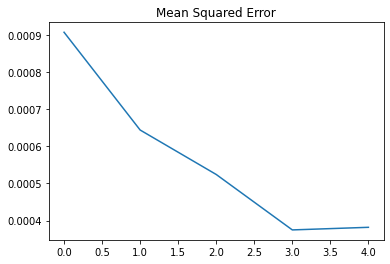

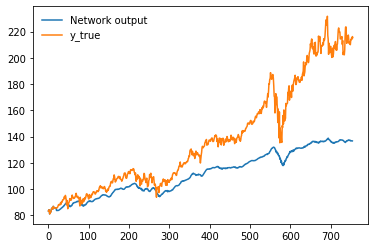

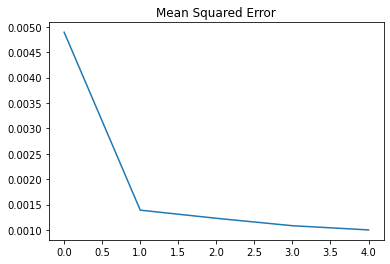

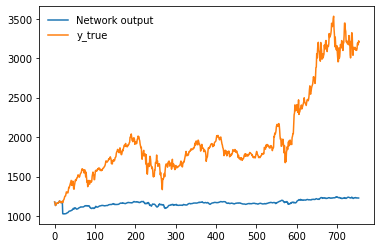

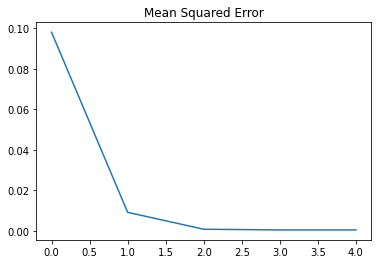

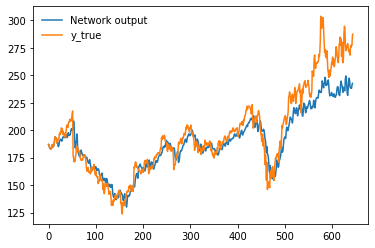

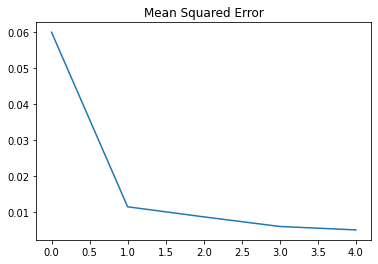

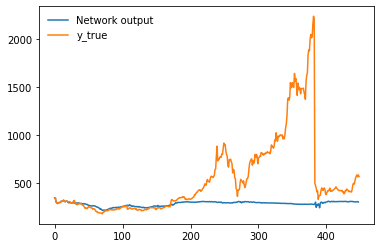

In [ ]:
all_prediction = pd.DataFrame()
 
for stock in os.listdir('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR)[:]  :
  print(stock)
  t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
  optimizer = torch.optim.Adam(t.parameters(), lr=lr)   
  
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR +  stock)
  x = int(len(data)*0.7)
  close = '<CLOSE>'
  #  train data
  instrument_data, year_train = get_dummy_data(x, close = close)
  scaler = MinMaxScaler()
  instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()
 
  # test_data = np.arange(100, 150, dtype=np.float32)
  test_data, year_test = get_dummy_data_test(x, close = close)
  true_seq = test_data.copy()
 
  test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
  X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
  print(instrument_data.shape, X_test.shape, y_test.shape)
 
  t = traina(instrument_data, epochs = 5, MY_FORCE=10)
  prediction = predi()

  # t, losses= train(instrument_data=instrument_data, batch_size=batch_size, epochs = 10)
  # prediction = pred(X_test=X_test, t = t)
 
  # prediction = prediction.flatten()
 
  all_prediction = pd.concat([all_prediction, pd.DataFrame({'forec': prediction, 'true_seq': true_seq[:-1], 'stock': stock.split('.')[-2]})])

# Pivot_table

In [ ]:
threshold = 0.
index_for = [ 'forecast_threshold']
 
# profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq[:-1]})
profit_table = all_prediction.copy()
profit_table['Profit']   = ((profit_table['true_seq'].shift(-1) / profit_table['true_seq']- 1) * 100)
profit_table['Profit_forec']   = ((profit_table['forec'].shift(-1) / profit_table['forec']- 1) * 100)
profit_table['forecast'] = np.where((profit_table['forec'].shift(-1) / profit_table['forec']- 1) > 0, 1, -1)
profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
profit_table['Dif']      = (profit_table['true_seq'] - profit_table['forecast']) / profit_table['true_seq']  
# profit_table['Data']     = year_test['<DATE>']
# profit_table['Data']     = np.array(pd.to_datetime(profit_table['Data']))
# profit_table['Year'] = profit_table['Data'].dt.year
profit_table['Profit'] = np.where(profit_table['Profit']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit']))
profit_table['Profit_forec'] = np.where(profit_table['Profit_forec']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit_forec']))
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = index_for,
                values = 'Profit',
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

,count,mean
,Profit,Profit
forecast_threshold,,
-1,1120,0.26
1,1481,0.17
All,2601,0.21


In [ ]:
# 20//// > 1, 90/100

In [ ]:
# 20/// >1.5 4/5 

,count,mean
,Profit,Profit
forecast_threshold,,
-1,1201,0.12
1,1400,0.28
All,2601,0.21


,count,mean
,Profit,Profit
forecast_threshold,,
-1,542,0.23
0,1441,0.10
1,618,0.44
All,2601,0.21


In [ ]:
#  голубые фишки при > 0,5

,count,mean
,Profit,Profit
forecast_threshold,,
-1,1049,-0.11
0,3236,0.05
1,1192,0.17
All,5477,0.05


,count,mean
,Profit,Profit
forecast_threshold,,
-1,2643,0.02
0,2,0.00
1,2832,0.07
All,5477,0.05


In [ ]:
profit_table.to_excel(PATH + 'frts.xlsx')

In [ ]:
def pivot(threshold = 0.1, index_for = 'forecast'):
  profit_table = pd.DataFrame({'prediction':prediction, 'true':true_seq[:-1]})
  profit_table['Profit']   = ((profit_table['true'].shift(-1) / profit_table['true']- 1) * 100)
  profit_table['Profit_forec']   = ((profit_table['prediction'].shift(-1) / profit_table['prediction']- 1) * 100)
  profit_table['forecast'] = np.where((profit_table['prediction'].shift(-1) / profit_table['prediction']- 1) > 0, 1, -1)
  profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
  profit_table['Dif']      = (profit_table['true'] - profit_table['forecast']) / profit_table['true']  
  profit_table['Data']     = data['<DATE>']
  profit_table['Year'] = profit_table['Data'].dt.year
  profit_table.dropna(inplace = True)
  return pd.pivot_table(profit_table,
                index = [index_for],
                values = 'Profit',
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2), profit_table

In [ ]:
_, profit_table = pivot(index_for='forecast_threshold')
profit_table
print(_,)

                    count   mean
                   Profit Profit
forecast_threshold              
-1                    187   0.21
0                      31   0.24
1                     229   0.56
All                   447   0.39
